# Capacity allocation

## 0. Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from benchmarks.generator import get_revenue_behaviour, get_revenue_behaviour_deprecated
from benchmarks.robin_railway import RevenueMaximization
from benchmarks.utils import sns_box_plot, sns_line_plot, int_input, get_schedule_from_supply, infer_line_stations, get_services_by_tsp_df, plot_marey_chart
from src.entities import GSA, Solution

from robin.scraping.entities import SupplySaver
from robin.services_generator.entities import ServiceGenerator
from robin.supply.entities import Service, Supply

from pathlib import Path
from typing import Any, List, Mapping, Tuple, Union
import shutil

In [2]:
# Config files
supply_config_path = Path("../configs/generator/supply_config.yml")
demand_config_path = Path("../configs/demand/demand.yml")
generator_config_path = Path("../configs/generator/generator_config.yml")

# Save paths
generator_save_path = Path(f'../data/generator/supply_dummy.yml')
supply_save_path = '../configs/mealpy/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(generator_save_path.parent).exists():
    shutil.rmtree(generator_save_path.parent)

Path(generator_save_path.parent).mkdir(parents=True)

if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

if Path(figures).exists():
    shutil.rmtree(figures)

Path(figures).mkdir(parents=True)

In [3]:
seed = 21

if generator_config_path:
    n_services = int_input("Number of services to generate: ")
    generator = ServiceGenerator(supply_config_path=supply_config_path)
    _ = generator.generate(file_name=generator_save_path,
                           path_config=generator_config_path,
                           n_services=n_services,
                           seed=seed)
    print(f'Number of service requests generated: {len(_)}')

Number of service requests generated: 25


In [4]:
supply = Supply.from_yaml(generator_save_path)
tsp_df = get_services_by_tsp_df(supply.services)

print(tsp_df)

       Number of Services
RU2                     4
RU3                    10
RU1                     6
RU4                     5
Total                  25


In [5]:
print("Services: ", len(supply.services))
requested_schedule = get_schedule_from_supply(generator_save_path)
revenue_behaviour = get_revenue_behaviour_deprecated(supply)
lines = supply.lines
line = infer_line_stations(lines)

Services:  25


/Users/david/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


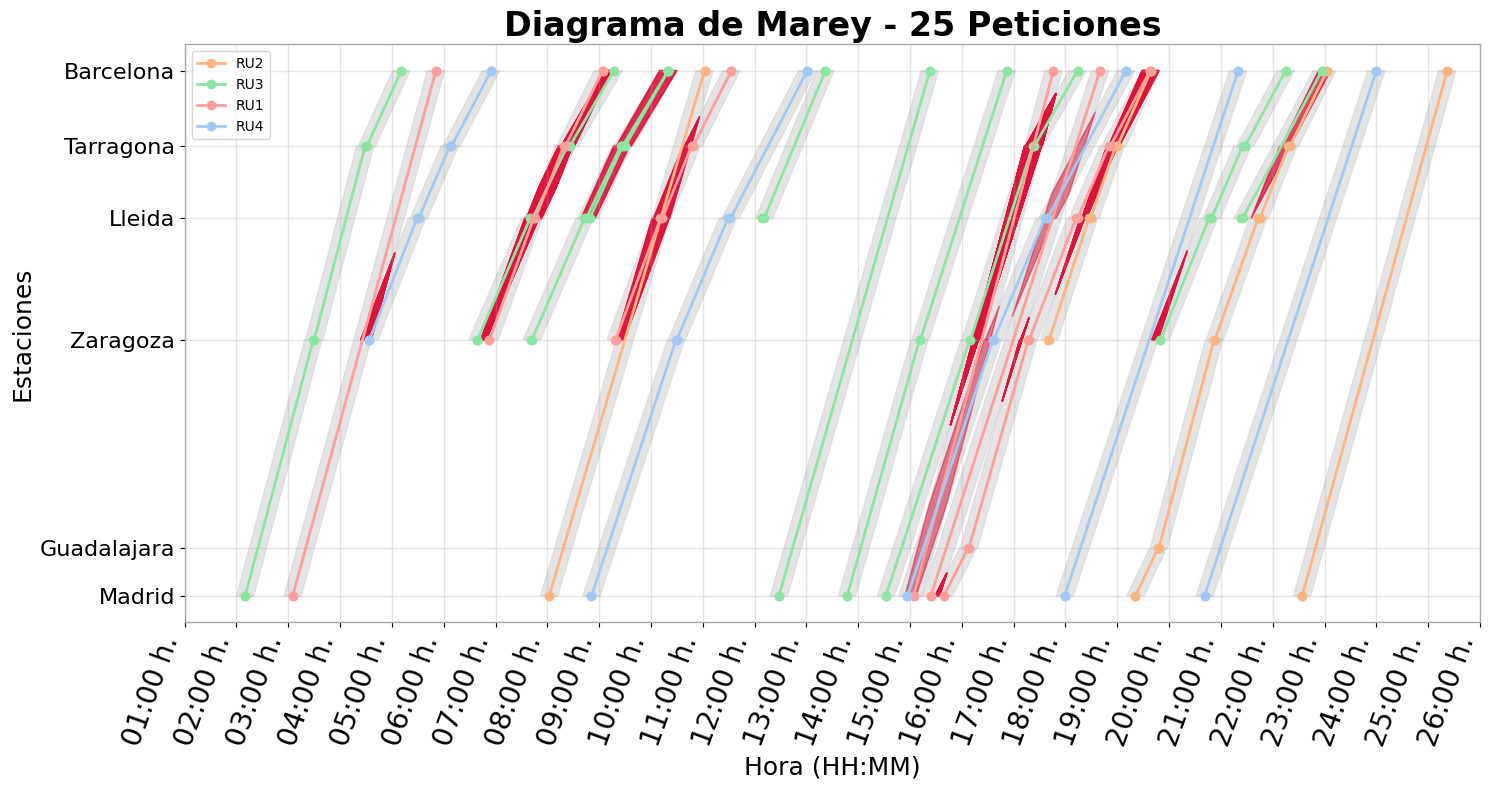

In [6]:
plot_marey_chart(requested_supply=supply,
                 colors_by_tsp=True, 
                 main_title="Diagrama de Marey - 25 Peticiones",
                 plot_security_gaps=True,
                 security_gap=10,
                 save_path=Path('../reports/gsa/marey_chart_requests_25.pdf'))

## 1. Mealpy

In [7]:
from src.timetabling_problem import MPTT

mptt = MPTT(requested_schedule=requested_schedule,
            revenue_behaviour=revenue_behaviour,
            line=line,
            safe_headway=10)

In [8]:
from mealpy.evolutionary_based import DE, ES, GA
from mealpy.swarm_based import ABC, ACOR, GWO, PSO, WOA
from mealpy.physics_based import SA

mp_algos = {"Genetic Algorithm": GA.BaseGA,
            "Particle Swarm Optimization": PSO.OriginalPSO,
            "Simulated Annealing": SA.OriginalSA,
            "Differential Evolution": DE.OriginalDE,
            "Ant Colony Optimization Continuous (ACOR)": ACOR.OriginalACOR,
            "Covariance Matrix Adaptation Evolution Strategy": ES.CMA_ES,
            "Artificial Bee Colony": ABC.OriginalABC,
            "Grey Wolf Optimizer": GWO.OriginalGWO,
            "Whale Optimization Algorithm": WOA.OriginalWOA,
            "Hybrid Grey Wolf - Whale Optimization Algorithm": GWO.GWO_WOA}

In [22]:
from mealpy import IntegerVar

runs = 2
epochs = 100
pop_size = 50

# 0. Problem formulation
lb, ub = zip(*mptt.boundaries.real)

problem = {"obj_func": mptt.objective_function,
           "bounds": IntegerVar(lb=lb,
                              ub=ub),
           "minmax": "max"}

# 1. Iter algorithms
df_history = pd.DataFrame()
df_population = pd.DataFrame()

for algo_name, algo in mp_algos.items():
    print(f"Running {algo_name}")
    for r in range(1, runs+1):
        print("\tRun: ", i)
        
        # Run algorithm
        if algo_name == "Simulated Annealing":
            epochs = epochs * pop_size
            pop_size = 1
        
        optimizer = algo(epoch=epochs, pop_size=pop_size)
        optimizer.solve(problem)
        
        # Build run history dataframe
        columns = ['Iteration', 'Fitness', 'ExecutionTime', 'Discrete', 'Real', 
                   'Diversity', 'Exploitation', 'Exploration']
        run_history = pd.DataFrame(columns=columns)
        
        # Save optimizer history to dataframe
        for i, data in enumerate(optimizer.history.list_global_best):
            mptt.update_schedule(data.solution)
            run_history.loc[i] = [i, 
                                  data.target.fitness,
                                  optimizer.history.list_epoch_time[i],
                                  mptt.get_heuristic_schedule(),
                                  data.solution,
                                  optimizer.history.list_diversity[i],
                                  optimizer.history.list_exploitation[i],
                                  optimizer.history.list_exploration[i]]
    
        run_history.insert(0, "Run", r)
        df_history = pd.concat([df_history, run_history], axis=0)
        
        # Population dataframe
        if algo_name == "Simulated Annealing":
            continue
            
        population_colums = [f'real_{i}' for i in range(pop_size)] + [f'discrete_{i}' for i in range(pop_size)]
        population_colums.insert(0, 'Iteration')
        run_population = pd.DataFrame(columns=population_colums)
        
        for i, pop_epoch in enumerate(optimizer.history.list_population):
            population_row = [i]
            real = []
            discrete = [] 
            for individual in pop_epoch:
                mptt.update_schedule(individual.solution)
                real.append(individual.solution)
                discrete.append(mptt.get_heuristic_schedule())
            
            population_row = [i, *real, *discrete]
            run_population.loc[len(run_population)] = population_row
        
        run_population.insert(0, "Run", r)
        df_population = pd.concat([df_population, run_population], axis=0)    

2024/11/19 12:27:33 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: Solving single objective optimization problem.


Running Genetic Algorithm
Run:  1


2024/11/19 12:27:34 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2384.0780077520526, Global best: 2699.410713358452, Runtime: 0.26377 seconds
2024/11/19 12:27:34 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2929.9960883402955, Global best: 2929.9960883402955, Runtime: 0.26490 seconds
2024/11/19 12:27:34 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 3093.0647907623597, Global best: 3093.0647907623597, Runtime: 0.25898 seconds
2024/11/19 12:27:35 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3321.2770081354256, Global best: 3321.2770081354256, Runtime: 0.28923 seconds
2024/11/19 12:27:35 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3158.4068348705837, Global best: 3321.2770081354256, Runtime: 0.26354 seconds
2024/11/19 12:27:35 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P,

Best solution: [1062. 1106. 1137.  871.  969. 1043.  912.  827.  912. 1354.  731.  129.
  209.  279.  472.  530.  629.  692.  919.  748.  185.  399.  463.  514.
  939.  969. 1039. 1100. 1138. 1161. 1188. 1253. 1312. 1349.  420.  476.
  511.  274.  331.  369.  523.  566. 1071. 1190. 1249. 1290.  559.  613.
  649. 1241.  462.  525.  567. 1278.  897.  998. 1060.]
Best fitness: 4297.96829280089
Execution time: 26.587796370999797
Run:  2


2024/11/19 12:28:01 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2554.250479630367, Global best: 2554.250479630367, Runtime: 0.25821 seconds
2024/11/19 12:28:01 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2592.123590983309, Global best: 2592.123590983309, Runtime: 0.26461 seconds
2024/11/19 12:28:01 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2926.073245457317, Global best: 2926.073245457317, Runtime: 0.26045 seconds
2024/11/19 12:28:02 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3050.900187723026, Global best: 3050.900187723026, Runtime: 0.26211 seconds
2024/11/19 12:28:02 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3281.384359970747, Global best: 3281.384359970747, Runtime: 0.26222 seconds
2024/11/19 12:28:02 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 6

Best solution: [1066. 1108. 1140.  871.  969. 1043.  909.  826.  912. 1354.  731.  128.
  209.  280.  485.  530.  629.  692.  916.  748.  178.  398.  463.  513.
  939.  969. 1042. 1100. 1138. 1161. 1188. 1254. 1315. 1350.  418.  474.
  511.  273.  331.  369.  537.  567. 1069. 1190. 1249. 1290.  557.  612.
  649. 1241.  460.  525.  567. 1281.  897.  998. 1062.]
Best fitness: 4237.733552961651
Execution time: 26.447063546999743
Running Particle Swarm Optimization
Run:  1


2024/11/19 12:28:28 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 1, Current best: 2613.587521423356, Global best: 2613.587521423356, Runtime: 0.26151 seconds
2024/11/19 12:28:28 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 2, Current best: 2613.587521423356, Global best: 2613.587521423356, Runtime: 0.26172 seconds
2024/11/19 12:28:28 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 3, Current best: 2626.090415353603, Global best: 2626.090415353603, Runtime: 0.25669 seconds
2024/11/19 12:28:28 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 4, Current best: 2626.090415353603, Global best: 2626.090415353603, Runtime: 0.25838 seconds
2024/11/19 12:28:29 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 5, Current best: 2678.3082907630787, Global best: 2678.3082907630787, Runtime: 0.25872 seconds
2024/11/19 12:28:29 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 6, Cu

Best solution: [1065.41970373 1107.93949086 1139.73824733  865.57252805  963.23873691
 1040.37707409  907.1680889   824.58006304  909.93799238 1348.71516438
  728.52684028  124.5573784   205.2096881   280.36411143  487.97549086
  522.12170806  622.85319029  686.05630091  930.61884866  751.17479285
  178.05778417  395.54096562  463.88815865  514.8724518   939.11945944
  968.68911553 1041.45047337 1101.08118828 1141.03002317 1161.17842371
 1191.64264071 1261.58403667 1313.63944332 1349.61795749  415.48395544
  475.53640096  510.99836624  274.6416361   332.44347187  373.09501953
  534.65208581  566.49779837 1070.92525563 1190.96105597 1249.28527878
 1292.95415108  551.3374231   611.57127844  647.40892866 1241.0430007
  456.61815373  521.14252711  565.59768218 1280.85851477  897.99999941
  997.85774146 1062.30474896]
Best fitness: 3818.175594999292
Execution time: 25.941391709000243
Run:  2


2024/11/19 12:28:54 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 1, Current best: 2246.1701146233927, Global best: 2246.1701146233927, Runtime: 0.25765 seconds
2024/11/19 12:28:54 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 2, Current best: 2246.1701146233927, Global best: 2246.1701146233927, Runtime: 0.25793 seconds
2024/11/19 12:28:54 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 3, Current best: 2256.2055811859477, Global best: 2256.2055811859477, Runtime: 0.25866 seconds
2024/11/19 12:28:55 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 4, Current best: 2493.9477613292343, Global best: 2493.9477613292343, Runtime: 0.25861 seconds
2024/11/19 12:28:55 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 5, Current best: 2493.9477613292343, Global best: 2493.9477613292343, Runtime: 0.25836 seconds
2024/11/19 12:28:55 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoc

Best solution: [1052.9014896  1110.48521097 1135.66071593  869.38388174  967.2171224
 1041.52545985  901.7203926   825.78059753  911.18347184 1347.08645779
  725.0163136   126.3446056   208.33386579  280.97247328  481.11434805
  531.40327713  623.58412779  687.90227071  923.59713001  743.06613596
  184.33958016  400.92161556  464.56766117  514.40748907  929.53174888
  970.72417665 1044.59112061 1100.32636601 1139.10819705 1163.96965469
 1192.68279633 1262.24391915 1314.74075793 1350.25468535  413.3082851
  474.02443789  510.69205389  266.5584457   332.23773444  370.20273282
  538.98266665  568.12890428 1078.37182363 1187.2647312  1247.94019434
 1290.41649906  555.67820696  614.96147957  650.90954108 1237.6108003
  457.96378835  520.50208281  562.48135705 1279.50111551  895.2907111
  999.47614561 1061.02010251]
Best fitness: 3422.8089925695135
Execution time: 26.205867419000185
Running Simulated Annealing
Run:  1


2024/11/19 12:29:20 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 1, Current best: 2142.738081798918, Global best: 2142.738081798918, Runtime: 0.00569 seconds
2024/11/19 12:29:20 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 2, Current best: 2142.738081798918, Global best: 2142.738081798918, Runtime: 0.00528 seconds
2024/11/19 12:29:20 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 3, Current best: 2142.738081798918, Global best: 2142.738081798918, Runtime: 0.00570 seconds
2024/11/19 12:29:20 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 4, Current best: 2142.738081798918, Global best: 2142.738081798918, Runtime: 0.00538 seconds
2024/11/19 12:29:20 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 5, Current best: 2143.0933920667417, Global best: 2143.0933920667417, Runtime: 0.00549 seconds
2024/11/19 12:29:20 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 6, Cu

Best solution: [1068.7534526  1110.45194761 1137.51281214  863.36583722  969.63695354
 1035.79955974  906.83909998  833.53507924  910.80059884 1358.79020295
  734.41299766  121.83486534  208.60854892  278.38263766  475.98754095
  523.28057121  623.51805194  685.81754112  915.34322828  749.85100163
  174.9116294   408.29811253  469.10103688  516.86984044  936.80116875
  976.06479076 1040.44616141 1100.43753909 1138.02339323 1157.38825114
 1189.59436574 1254.57273233 1312.60014852 1349.60332341  407.8129601
  472.33480026  512.27565292  282.67616002  331.48755925  372.55343801
  532.06218864  568.49592839 1089.36388182 1188.72630618 1250.72541813
 1291.96403718  558.81570433  609.33746909  649.26377177 1232.20795685
  452.40373047  519.2256537   559.14983111 1279.74457403  901.91197441
 1001.77010545 1063.80645364]
Best fitness: 2199.258838257281
Execution time: 0.571125919999929
Run:  2


2024/11/19 12:29:21 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 1, Current best: 2151.951422146405, Global best: 2151.951422146405, Runtime: 0.00506 seconds
2024/11/19 12:29:21 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 2, Current best: 2151.951422146405, Global best: 2151.951422146405, Runtime: 0.00527 seconds
2024/11/19 12:29:21 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 3, Current best: 2151.951422146405, Global best: 2151.951422146405, Runtime: 0.00573 seconds
2024/11/19 12:29:21 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 4, Current best: 2151.951422146405, Global best: 2151.951422146405, Runtime: 0.00548 seconds
2024/11/19 12:29:21 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 5, Current best: 2151.951422146405, Global best: 2151.951422146405, Runtime: 0.00535 seconds
2024/11/19 12:29:21 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 6, Curr

Best solution: [1057.9207211  1110.79404949 1138.67833615  863.73120029  961.43617847
 1037.51913209  905.85052586  825.88319483  910.37045651 1349.1603635
  731.42609826  122.28432527  203.87733818  280.65766321  489.56585497
  530.74213841  621.45182957  686.50797618  919.44877355  739.78066555
  175.64264017  407.62107456  469.14628878  516.26539847  932.44804863
  970.98234678 1041.65217085 1104.60938527 1142.78071887 1163.36077459
 1194.1013752  1259.68621421 1314.85087868 1349.04193465  417.80566955
  473.9489434   512.0163428   276.35921882  334.43783792  365.63627798
  523.00246362  566.48310928 1086.10303531 1199.53721048 1247.07637064
 1295.39710285  560.7113504   612.76908848  647.93951886 1239.44928973
  452.99416343  518.30114017  564.52619342 1277.33742124  894.30929511
  997.31975405 1062.81151811]
Best fitness: 2705.877082804271
Execution time: 0.5447059179999769
Running Differential Evolution
Run:  1


2024/11/19 12:29:22 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 2, Current best: 2402.8965255372545, Global best: 2402.8965255372545, Runtime: 0.26315 seconds
2024/11/19 12:29:23 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 3, Current best: 2564.030995126348, Global best: 2564.030995126348, Runtime: 0.25940 seconds
2024/11/19 12:29:23 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 4, Current best: 2564.030995126348, Global best: 2564.030995126348, Runtime: 0.25979 seconds
2024/11/19 12:29:23 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 5, Current best: 2794.6937058302024, Global best: 2794.6937058302024, Runtime: 0.26355 seconds
2024/11/19 12:29:23 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 6, Current best: 2794.6937058302024, Global best: 2794.6937058302024, Runtime: 0.26175 seconds
2024/11/19 12:29:24 PM, INFO, mealpy.evolutionary_based.DE.Origi

Best solution: [1061.62389983 1111.61476105 1136.83056304  861.97296264  968.37623903
 1042.81444667  914.23824475  819.0759921   915.51642501 1357.60029806
  731.44235908  128.26876457  209.27388864  281.14403099  480.4885698
  522.44789463  622.06974504  687.47663831  934.2203161   753.58300774
  182.08141547  399.03577072  468.11871366  512.70594919  939.8698866
  973.27008727 1045.49739353 1103.01220853 1141.05789044 1161.13821988
 1188.82763459 1258.30442708 1312.76693392 1348.95416649  413.39217184
  473.26780293  511.          269.17636135  331.22295119  369.7445723
  533.82599485  566.7162423  1075.84273307 1191.46562386 1250.72654049
 1294.30750059  555.29596182  610.47687162  648.39075853 1241.62676942
  458.15173791  522.35549553  565.57331558 1278.06544738  894.23233439
  999.76491993 1061.69431455]
Best fitness: 3758.2552153370475
Execution time: 26.229741913999646
Run:  2


2024/11/19 12:29:49 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 1, Current best: 2268.2241498616336, Global best: 2268.2241498616336, Runtime: 0.26123 seconds
2024/11/19 12:29:49 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 2, Current best: 2525.188781350452, Global best: 2525.188781350452, Runtime: 0.25843 seconds
2024/11/19 12:29:49 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 3, Current best: 2755.2907866250653, Global best: 2755.2907866250653, Runtime: 0.25669 seconds
2024/11/19 12:29:50 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 4, Current best: 2755.2907866250653, Global best: 2755.2907866250653, Runtime: 0.25486 seconds
2024/11/19 12:29:50 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 5, Current best: 2755.2907866250653, Global best: 2755.2907866250653, Runtime: 0.25749 seconds
2024/11/19 12:29:50 PM, INFO, mealpy.evolutionary_based.DE.Ori

Best solution: [1055.23831957 1114.17928186 1134.18573721  865.15380099  967.07091155
 1043.4692746   904.28390377  819.01922872  912.21069746 1354.68191695
  729.19661508  122.20417117  209.4308522   279.22378678  475.15399444
  523.50216246  625.15032774  687.35191894  919.76525341  748.1184071
  184.31062141  400.4527094   470.36269702  513.53944144  939.42664629
  969.57818128 1044.47426966 1103.72946928 1142.0735982  1161.08879818
 1188.89211546 1258.98367145 1314.95734244 1350.19865178  410.96545759
  475.52219905  511.          268.52581282  329.08006744  369.37157239
  532.27928639  570.82414281 1075.08775567 1198.9294702  1251.4845599
 1294.41681888  555.75302594  613.73352605  650.78900831 1241.73894515
  451.64235641  523.15556269  566.08835686 1277.26077798  892.13540873
  999.866175   1062.22010272]
Best fitness: 3648.985618879304
Execution time: 26.16113008899987
Running Ant Colony Optimization Continuous (ACOR)
Run:  1


2024/11/19 12:30:15 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 1, Current best: 2139.8867382697076, Global best: 2139.8867382697076, Runtime: 0.16048 seconds
2024/11/19 12:30:15 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 2, Current best: 2435.4813753988856, Global best: 2435.4813753988856, Runtime: 0.15461 seconds
2024/11/19 12:30:15 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 3, Current best: 2435.4813753988856, Global best: 2435.4813753988856, Runtime: 0.15565 seconds
2024/11/19 12:30:16 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 4, Current best: 2435.4813753988856, Global best: 2435.4813753988856, Runtime: 0.15651 seconds
2024/11/19 12:30:16 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 5, Current best: 2498.3849569710433, Global best: 2498.3849569710433, Runtime: 0.15436 seconds
2024/11/19 12:30:16 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Prob

Best solution: [1060.15150251 1112.08450164 1137.91932814  864.06708977  963.58663833
 1043.4999      896.67809565  816.5         911.05480849 1354.69838511
  739.02532085  120.41643931  207.52035415  280.24820429  492.4999
  522.18671218  629.4999      692.4999      932.10828073  738.58228562
  195.4999      392.8835143   469.93127332  515.39236272  938.32427992
  969.0724568  1043.56863621 1104.4999     1142.00650752 1152.61844917
 1189.39959804 1258.91740996 1313.67141887 1350.11565542  420.54533833
  475.71888883  511.          270.39828125  331.59269962  369.33516762
  538.81668667  565.65886175 1071.20418196 1190.47589156 1252.4999
 1292.8466904   552.4940524   609.99397603  653.05560038 1251.4999
  451.5         524.23511853  567.4999     1277.67888361  890.16055633
 1000.45151399 1066.4177809 ]
Best fitness: 3647.193891110932
Execution time: 15.741557169999396
Run:  2


2024/11/19 12:30:31 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 1, Current best: 2378.597540905785, Global best: 2378.597540905785, Runtime: 0.15716 seconds
2024/11/19 12:30:31 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 2, Current best: 2439.9666855674213, Global best: 2439.9666855674213, Runtime: 0.15606 seconds
2024/11/19 12:30:31 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 3, Current best: 2439.9666855674213, Global best: 2439.9666855674213, Runtime: 0.15286 seconds
2024/11/19 12:30:32 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 4, Current best: 2439.9666855674213, Global best: 2439.9666855674213, Runtime: 0.15567 seconds
2024/11/19 12:30:32 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 5, Current best: 2530.598947305766, Global best: 2530.598947305766, Runtime: 0.15535 seconds
2024/11/19 12:30:32 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem:

Best solution: [1071.4999     1114.4999     1138.36614185  863.4379597   968.29304679
 1042.22800198  901.3513236   816.5         912.98080107 1345.84885779
  733.76324943  122.04960984  208.99039448  281.4999      492.01294796
  520.90642928  624.37656769  688.39702366  920.73726836  758.4999
  195.4999      403.83303208  469.94962162  516.4999      934.98890209
  968.5        1042.67048605 1099.5        1140.64845805 1153.38104606
 1187.5        1255.91765054 1313.34449978 1350.35225507  414.94460079
  474.30129803  511.          266.6445778   330.27679593  369.2975046
  526.76052474  566.11469018 1068.5        1190.47263155 1252.4999
 1292.64762409  550.62581481  612.70639188  653.4999     1238.13131933
  452.52693743  517.63774274  567.05260177 1275.20222293  886.68870798
  998.56365115 1062.2760201 ]
Best fitness: 3641.4133359836374
Execution time: 15.776072716000613
Running Covariance Matrix Adaptation Evolution Strategy
Run:  1


2024/11/19 12:30:50 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 1, Current best: 2221.7754338027944, Global best: 2222.4484665358304, Runtime: 1.09833 seconds
2024/11/19 12:30:51 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 2, Current best: 2149.8940587011866, Global best: 2222.4484665358304, Runtime: 0.87890 seconds
2024/11/19 12:30:52 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 3, Current best: 1914.8023910581687, Global best: 2222.4484665358304, Runtime: 0.96626 seconds
2024/11/19 12:30:52 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 4, Current best: 1960.9274871669572, Global best: 2222.4484665358304, Runtime: 0.80642 seconds
2024/11/19 12:30:53 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 5, Current best: 2194.123089352198, Global best: 2222.4484665358304, Runtime: 0.76591 seconds
2024/11/19 12:30:54 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P,

Best solution: [1061.22948747 1111.31604726 1140.16574024  871.86099792  966.33288642
 1038.29025841  910.67099413  825.45204979  911.80275678 1352.15019404
  729.16286819  126.79634026  206.42538591  280.80942891  481.79370529
  531.10770214  625.58170427  688.24944175  922.81531438  747.59863697
  185.51180856  395.43521329  464.00318985  513.40827169  941.21520429
  970.5673974  1040.57692832 1102.11461088 1140.48453322 1170.6449861
 1194.59579097 1255.86226055 1313.07069631 1349.97641213  404.39804592
  475.01657025  511.21669668  273.65877378  331.39368721  369.52175508
  522.32898467  568.68341722 1081.55385623 1190.26821298 1249.2573912
 1294.18940917  560.86103979  616.08894647  648.43188723 1236.81644657
  456.97040502  520.90221252  561.56922379 1293.97057545  896.6735662
 1002.52349291 1064.25680277]
Best fitness: 2262.878067886173
Execution time: 81.59334812399982
Run:  2


2024/11/19 12:32:12 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 1, Current best: 2771.7283940683747, Global best: 2771.7283940683747, Runtime: 0.65751 seconds
2024/11/19 12:32:12 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 2, Current best: 2314.430157785657, Global best: 2771.7283940683747, Runtime: 0.67846 seconds
2024/11/19 12:32:13 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 3, Current best: 2166.8366183955304, Global best: 2771.7283940683747, Runtime: 0.65527 seconds
2024/11/19 12:32:14 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 4, Current best: 2097.103438986831, Global best: 2771.7283940683747, Runtime: 0.63105 seconds
2024/11/19 12:32:14 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 5, Current best: 2186.3710013820582, Global best: 2771.7283940683747, Runtime: 0.61965 seconds
2024/11/19 12:32:15 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, 

Best solution: [1063.18311045 1111.48559971 1137.71198883  874.56290546  967.905555
 1038.74649657  901.939694    822.43425544  913.82421285 1353.8718615
  728.53910185  124.56768545  207.57359411  281.0180703   478.10352342
  524.21139847  624.53668381  688.25086399  919.59399766  747.62345169
  180.37974455  401.84151873  468.42269677  514.73496243  943.4906739
  973.71655928 1043.03072225 1102.40399922 1140.93846501 1157.07029085
 1192.30104545 1259.06558558 1313.80552944 1349.7110542   423.4999
  475.20723588  511.04542211  271.58187318  332.02809162  370.5275712
  534.1940065   565.85405721 1079.53509327 1188.14386914 1250.31304938
 1293.12580647  567.18794597  610.94402535  647.26291972 1239.81317417
  456.13312093  520.41004436  562.01264264 1280.33209289  898.9612403
 1000.68710817 1062.86222504]
Best fitness: 3080.8891854225126
Execution time: 61.777029836999304
Running Artificial Bee Colony
Run:  1


2024/11/19 12:33:14 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 1, Current best: 2340.568229593809, Global best: 2340.568229593809, Runtime: 0.50420 seconds
2024/11/19 12:33:14 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 2, Current best: 2423.316987975014, Global best: 2423.316987975014, Runtime: 0.49925 seconds
2024/11/19 12:33:15 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 3, Current best: 2423.316987975014, Global best: 2423.316987975014, Runtime: 0.50347 seconds
2024/11/19 12:33:15 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 4, Current best: 2714.551926923768, Global best: 2714.551926923768, Runtime: 0.49905 seconds
2024/11/19 12:33:16 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 5, Current best: 2812.920544342316, Global best: 2812.920544342316, Runtime: 0.49999 seconds
2024/11/19 12:33:16 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 6, Curr

Best solution: [1058.66351829 1105.75624556 1138.76460804  867.6480189   966.75368645
 1040.78006425  898.61181009  831.24404013  917.21465293 1343.5
  735.75195911  119.89095117  207.26041631  279.49048995  471.86455845
  520.5         619.5         690.48252781  934.4999      739.19241713
  179.53360615  393.32774807  470.4999      514.46457577  928.5
  971.21778629 1045.4999     1102.81278905 1142.4999     1150.5
 1187.5        1255.76424139 1313.80754416 1349.61988277  404.04352412
  472.5         511.          272.22456006  331.46767681  369.44073558
  518.51414426  570.54871974 1068.5        1188.36169514 1249.80171646
 1293.16365356  548.5         613.50459133  653.4999     1233.99284783
  454.82847028  520.2110686   563.39342816 1274.5         896.5836331
 1001.06863128 1065.17981803]
Best fitness: 3596.2937443250944
Execution time: 51.48921028900031
Run:  2


2024/11/19 12:34:06 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 2, Current best: 2958.454383991164, Global best: 2958.454383991164, Runtime: 0.50027 seconds
2024/11/19 12:34:07 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 3, Current best: 2958.454383991164, Global best: 2958.454383991164, Runtime: 0.50189 seconds
2024/11/19 12:34:07 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 4, Current best: 2958.454383991164, Global best: 2958.454383991164, Runtime: 0.49873 seconds
2024/11/19 12:34:08 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 5, Current best: 2958.454383991164, Global best: 2958.454383991164, Runtime: 0.54472 seconds
2024/11/19 12:34:08 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 6, Current best: 2958.454383991164, Global best: 2958.454383991164, Runtime: 0.53026 seconds
2024/11/19 12:34:09 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 7, Curr

Best solution: [1054.36885376 1105.5        1138.54784053  865.0725243   964.66329505
 1042.78346532  904.62408754  821.64680647  911.0353103  1358.2393129
  732.09480602  121.76226203  207.52198895  280.60337551  483.25321685
  520.5         619.5         690.03016063  924.32578148  743.89017315
  183.08304267  388.5         465.21577544  514.19361439  929.74400202
  970.43531698 1043.66148679 1100.50953842 1140.69436753 1162.43108808
 1189.65028387 1256.57851067 1311.5        1349.05898562  412.73267841
  473.41290474  511.          273.08871671  332.29566341  370.91397862
  539.4999      572.4999     1068.5        1186.87092947 1247.5529998
 1297.4999      549.70172281  609.5         646.02351218 1239.34022358
  451.59512856  518.80949617  565.34621984 1276.08199641  894.36890221
  999.42318274 1061.6769165 ]
Best fitness: 3576.8771564815447
Execution time: 51.469177285999876
Running Grey Wolf Optimizer
Run:  1


2024/11/19 12:34:57 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 1, Current best: 2295.347748308412, Global best: 2295.347748308412, Runtime: 0.25215 seconds
2024/11/19 12:34:57 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 2, Current best: 2295.347748308412, Global best: 2295.347748308412, Runtime: 0.25356 seconds
2024/11/19 12:34:58 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 3, Current best: 2295.347748308412, Global best: 2295.347748308412, Runtime: 0.25408 seconds
2024/11/19 12:34:58 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 4, Current best: 2295.347748308412, Global best: 2295.347748308412, Runtime: 0.25180 seconds
2024/11/19 12:34:58 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 5, Current best: 2295.347748308412, Global best: 2295.347748308412, Runtime: 0.25334 seconds
2024/11/19 12:34:58 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 6, Curr

Best solution: [1067.55063993 1108.34605742 1134.70546515  862.43634817  964.47432408
 1039.17188964  898.29067686  819.56844512  908.98991069 1362.61964872
  734.21193826  122.59271375  209.4999      279.78978622  484.24214225
  535.40476189  622.04512686  689.01449453  922.92044477  754.05196198
  190.48510491  388.5         463.04861262  513.3796974   934.99651802
  968.5        1043.66771263 1104.4999     1142.4999     1154.49428203
 1187.5        1256.55052718 1311.5        1348.5         413.83704019
  476.4999      511.4999      265.42140148  329.86698036  370.51769883
  533.03759087  572.4999     1075.77260949 1180.819087   1249.80126472
 1296.15555362  548.54352659  615.13079316  653.4999     1248.95405244
  451.73785712  523.73578669  565.49880753 1279.17632514  894.56446522
  997.5        1065.77043791]
Best fitness: 3126.328291754206
Execution time: 25.403098877999355
Run:  2


2024/11/19 12:35:23 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 1, Current best: 2249.1232407438124, Global best: 2249.1232407438124, Runtime: 0.25493 seconds
2024/11/19 12:35:23 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 2, Current best: 2249.1232407438124, Global best: 2249.1232407438124, Runtime: 0.25412 seconds
2024/11/19 12:35:23 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 3, Current best: 2249.1232407438124, Global best: 2249.1232407438124, Runtime: 0.25485 seconds
2024/11/19 12:35:24 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 4, Current best: 2249.1232407438124, Global best: 2249.1232407438124, Runtime: 0.25330 seconds
2024/11/19 12:35:24 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 5, Current best: 2249.1232407438124, Global best: 2249.1232407438124, Runtime: 0.25235 seconds
2024/11/19 12:35:24 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoc

Best solution: [1057.5256976  1113.38644784 1133.5         861.5         961.30247795
 1040.50059834  907.3221025   828.94212394  913.65977607 1358.23973835
  726.24041768  120.68245744  207.63180023  278.5         477.58137151
  524.513039    627.40993984  689.72882035  928.81559191  745.72800776
  189.56919162  396.95669774  462.80067796  516.39556772  928.5
  974.46450078 1044.62346626 1103.02280588 1142.4999     1155.66011879
 1188.41827617 1254.35775261 1311.5        1348.5         412.05374692
  475.62463379  511.4999      271.27660581  328.5         369.48860119
  528.1393676   569.73584837 1083.7311891  1191.09208795 1252.4999
 1291.99903323  560.75126057  611.37835011  648.5879798  1245.65351892
  467.17758248  520.33967053  564.13257704 1287.8164729   891.04526649
  997.5        1067.4999    ]
Best fitness: 2826.401194022327
Execution time: 25.017828581000344
Running Whale Optimization Algorithm
Run:  1


2024/11/19 12:35:48 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 2, Current best: 2674.976031832013, Global best: 2674.976031832013, Runtime: 0.25523 seconds
2024/11/19 12:35:49 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 3, Current best: 2858.6764970719005, Global best: 2858.6764970719005, Runtime: 0.25543 seconds
2024/11/19 12:35:49 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 4, Current best: 2884.509897153333, Global best: 2884.509897153333, Runtime: 0.25716 seconds
2024/11/19 12:35:49 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 5, Current best: 2884.509897153333, Global best: 2884.509897153333, Runtime: 0.25490 seconds
2024/11/19 12:35:49 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 6, Current best: 2923.974544309202, Global best: 2923.974544309202, Runtime: 0.25504 seconds
2024/11/19 12:35:50 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 7, Cu

Best solution: [1055.54934357 1110.77461579 1138.95775917  866.20602586  965.13086649
 1043.40388309  897.73450108  820.4326587   911.84785066 1349.96058973
  738.29698044  120.0902431   209.172272    279.84342494  476.33879652
  523.42295133  628.59127171  692.47739714  918.08206436  741.79147381
  175.37632189  390.38999211  464.72760478  514.96524893  932.94465011
  973.16542909 1040.48681986 1104.38278208 1142.40882398 1156.0342901
 1193.33519744 1258.83091144 1315.45809807 1350.45867699  414.79420015
  474.88729035  511.48364635  264.78790952  330.11090137  369.56149151
  526.52594812  567.21883412 1083.59368562 1185.18266381 1251.77492973
 1295.60370396  556.6350928   612.43199387  651.99150417 1240.91983746
  468.06829539  519.99378451  561.19027713 1281.98823944  890.76534894
 1002.3036918  1066.89849121]
Best fitness: 2990.285445992062
Execution time: 25.425838209999824
Run:  2


2024/11/19 12:36:14 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 2, Current best: 2514.0208576006976, Global best: 2514.0208576006976, Runtime: 0.24935 seconds
2024/11/19 12:36:14 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 3, Current best: 2515.1719154658053, Global best: 2515.1719154658053, Runtime: 0.24983 seconds
2024/11/19 12:36:15 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 4, Current best: 2534.3275378711983, Global best: 2534.3275378711983, Runtime: 0.24890 seconds
2024/11/19 12:36:15 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 5, Current best: 2535.1891876437576, Global best: 2535.1891876437576, Runtime: 0.25270 seconds
2024/11/19 12:36:15 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 6, Current best: 2864.040755553059, Global best: 2864.040755553059, Runtime: 0.25153 seconds
2024/11/19 12:36:15 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch:

Best solution: [1055.74659475 1109.95168133 1137.88708772  865.02218606  964.49366463
 1038.72948518  898.02591749  824.56693466  911.50130268 1349.03951984
  723.44571684  120.90204113  203.76964918  279.63862892  482.4321767
  522.62803     622.03278499  687.59126574  923.37119586  743.79163887
  184.46169414  398.61573756  464.60834671  514.42124547  932.29611115
  972.45964852 1040.46307372 1100.89420843 1138.84589336 1155.20374354
 1192.57523276 1257.38208171 1312.60893825 1349.11642354  404.14559476
  474.43178516  510.79355186  273.36578194  330.06772519  369.96779483
  524.97570306  566.8079211  1073.77073682 1184.32230814 1247.61503697
 1292.45638407  557.50374901  611.99190064  647.13499584 1235.53081828
  454.29246117  519.83024361  561.09261511 1279.71070938  891.11722514
 1001.57821311 1063.2366861 ]
Best fitness: 3075.5914033901345
Execution time: 25.23927887299965
Running Hybrid Grey Wolf - Whale Optimization Algorithm
Run:  1


2024/11/19 12:36:39 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 1, Current best: 2478.7659632384025, Global best: 2478.7659632384025, Runtime: 0.25064 seconds
2024/11/19 12:36:40 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 2, Current best: 2478.7659632384025, Global best: 2478.7659632384025, Runtime: 0.24792 seconds
2024/11/19 12:36:40 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 3, Current best: 2478.7659632384025, Global best: 2478.7659632384025, Runtime: 0.24720 seconds
2024/11/19 12:36:40 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 4, Current best: 2478.7659632384025, Global best: 2478.7659632384025, Runtime: 0.25149 seconds
2024/11/19 12:36:40 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 5, Current best: 2478.7659632384025, Global best: 2478.7659632384025, Runtime: 0.25043 seconds
2024/11/19 12:36:41 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 6, Current best: 2478

Best solution: [1050.5        1105.5        1133.5         882.4999      970.4999
 1034.5         893.5         816.5         917.4999     1364.4999
  741.4999      140.4999      199.5         278.5         492.4999
  520.5         620.27472633  692.4999      913.5         758.4999
  195.4999      388.5         462.5         512.5         928.5
  968.5        1045.4999     1104.4999     1142.4999     1150.5
 1197.4999     1262.4999     1315.4999     1350.4999      402.53170557
  476.4999      510.5         263.5         328.5         364.5
  518.5         572.4999     1068.5        1179.5        1244.5
 1289.5         548.5         609.5         653.4999     1230.5
  451.5         517.5         567.4999     1274.5         886.5
  997.5        1067.4999    ]
Best fitness: 2689.8902104186145
Execution time: 24.99384787200063
Run:  2


2024/11/19 12:37:05 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 1, Current best: 2016.981426882871, Global best: 2016.981426882871, Runtime: 0.25090 seconds
2024/11/19 12:37:05 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 2, Current best: 2016.981426882871, Global best: 2016.981426882871, Runtime: 0.24918 seconds
2024/11/19 12:37:05 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 3, Current best: 2016.981426882871, Global best: 2016.981426882871, Runtime: 0.24958 seconds
2024/11/19 12:37:06 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 4, Current best: 2016.981426882871, Global best: 2016.981426882871, Runtime: 0.24981 seconds
2024/11/19 12:37:06 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 5, Current best: 2058.2258167557015, Global best: 2058.2258167557015, Runtime: 0.25238 seconds
2024/11/19 12:37:06 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 6, Current best: 2162.7218964

Best solution: [1050.5        1105.5        1142.4999      861.5         960.5
 1043.4999      914.4999      816.5         907.5        1364.4999
  720.5         119.5         209.4999      278.5         492.4999
  520.5         619.5         684.5         913.5         737.5
  195.4999      388.5         462.5         516.4999      928.5
  968.5        1035.5        1104.4999     1137.5        1171.4999
 1197.4999     1262.4999     1311.5        1348.5         423.4999
  476.4999      511.4999      263.5         328.65574939  373.4999
  539.4999      572.4999     1089.4999     1179.5        1244.5
 1289.5         548.5         609.5         653.4999     1251.4999
  451.5         518.71287519  567.4999     1295.4999      886.5
  997.5        1067.4999    ]
Best fitness: 2486.665307494216
Execution time: 25.00369808099981


In [27]:
for algo in mp_best_fit:
    print(f"Best fitness for {algo}: {mp_best_fit[algo]}")
    print(f"Execution time for {algo}: {mp_exec_time[algo]}")
    print()

Best fitness for Genetic Algorithm: 4237.733552961651
Execution time for Genetic Algorithm: 26.447063546999743

Best fitness for Particle Swarm Optimization: 3422.8089925695135
Execution time for Particle Swarm Optimization: 26.205867419000185

Best fitness for Simulated Annealing: 2751.8661491006574
Execution time for Simulated Annealing: 52.28657840000096

Best fitness for Differential Evolution: 3648.985618879304
Execution time for Differential Evolution: 26.16113008899987

Best fitness for Ant Colony Optimization Continuous (ACOR): 3641.4133359836374
Execution time for Ant Colony Optimization Continuous (ACOR): 15.776072716000613

Best fitness for Covariance Matrix Adaptation Evolution Strategy: 3080.8891854225126
Execution time for Covariance Matrix Adaptation Evolution Strategy: 61.777029836999304

Best fitness for Artificial Bee Colony: 3576.8771564815447
Execution time for Artificial Bee Colony: 51.469177285999876

Best fitness for Grey Wolf Optimizer: 2826.401194022327
Executi

In [ ]:
reports_path = Path('../reports/')

sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behaviour=revenue_behaviour,
                         line=line,
                         safe_headway=10)



for s_idx in range(89, 101): 
    times_sol = np.array(optimizer.history.list_global_best[s_idx].solution, dtype=int)
    
    mptt.update_schedule(mptt.best_solution.real)
    
    solution = Solution(real=times_sol, discrete=mptt.get_heuristic_schedule())

    services = sm.update_supply(path=generator_save_path,
                                solution=solution)
    
    sm.update_schedule(solution=solution)
    
    filtered_services = {}
    for i, service in enumerate(sm.updated_schedule):
        if mptt.best_solution.discrete[i]:
            filtered_services[service] = sm.updated_schedule[service]
    
    #plotter = TrainSchedulePlotter(filtered_services, line)
    #plotter.plot(plot_security_gaps=True, save_path=Path('../figures/updated.pdf'))
    
    tt_file_name = f'{supply_config_path.stem}_mptt_ga'
    print(supply_save_path, tt_file_name)
    SupplySaver(services).to_yaml(filename=f'{tt_file_name}.yml', save_path=supply_save_path)
    
    # Copy previous file in reports
    shutil.copyfile(f"{supply_save_path}{tt_file_name}.yml", reports_path / f'mealpy/{tt_file_name}_25_mptt_ga.yml')
    
    supply_config_file = Path(f'{supply_save_path}{tt_file_name}_25_mptt_ga.yml')
    
    final_supply = Supply.from_yaml("../reports/mealpy/supply_config_mptt_ga_25_mptt_ga.yml")
    
    plot_marey_chart(requested_supply=final_supply,
                     colors_by_tsp=True, 
                     main_title=f"Diagrama de Marey - 25 Peticiones {s_idx}",
                     plot_security_gaps=True,
                     security_gap=10,
                     save_path=Path('../reports/gsa/marey_chart_requests_25.pdf'))

In [46]:
#pr = profile.Profile()
#pr.enable()
import random

def run_mptt(runs: int=1,
            population_size: int=50,
            iters: int=100,
            global_seed: int=21
            ) -> Tuple[pd.DataFrame, pd.DataFrame, Any]:
    random.seed(global_seed)
    
    runs_best_solution_history = {}
    
    global_train_hist = pd.DataFrame()
    global_population_hist = pd.DataFrame()
    
    for r in range(1, runs + 1):
        print(f"Run {r}")
        
        mptt = MPTT(requested_schedule=requested_schedule,
                    revenue_behaviour=revenue_behaviour,
                    line=line,
                    safe_headway=10)
        
        # Set default box constraints
        lb, ub = zip(*mptt.boundaries.real)
        
        problem = {"obj_func": mptt.objective_function,
                   "bounds": IntegerVar(lb=lb,
                                      ub=ub),
                   "minmax": "max"}
        
        optimizer = GA.BaseGA(epoch=iters, pop_size=population_size)
        optimizer.solve(problem)
        
        columns = ['Iteration', 'Fitness', 'ExecutionTime', 'Discrete', 'Real']
        run_history = pd.DataFrame(columns=columns)
        
        # Save optimizer history to dataframe
        for i, data in enumerate(optimizer.history.list_global_best):
            
            mptt.update_schedule(data.solution)
            run_history.loc[i] = [i, 
                                  data.target.fitness,
                                  optimizer.history.list_epoch_time[i],
                                  mptt.get_heuristic_schedule(),
                                  data.solution]
    
        run_history.insert(0, "Run", r)
        global_train_hist = pd.concat([global_train_hist, run_history], axis=0)
        
        population_colums = [f'real_{i}' for i in range(population_size)] + [f'discrete_{i}' for i in range(population_size)]
        
        population_colums.insert(0, 'Iteration')
        population_history = pd.DataFrame(columns=population_colums)
        
        #population_row = [current_iter, *[p.real for p in pos], *[p.discrete for p in pos]]
        #population_history.loc[len(population_history)] = population_row
        
        #run_history = pd.DataFrame(columns=columns)
        #gsa_algo.population_history.insert(0, "Run", r)
        #global_population_hist = pd.concat([global_population_hist, gsa_algo.population_history], axis=0)
    
        runs_best_solution_history[r] = (mptt.best_solution, mptt.best_revenue)
        
    return global_train_hist, global_population_hist
        
#pr.disable()
#pr.dump_stats('profile.pstat')

In [47]:
runs = 5
population = 50
iters = 100
rbs_hist = {}

df_mp = pd.DataFrame()
df_pp = pd.DataFrame()

print(f"Running Mealpy")
df_gcc, df_gpp = run_mptt(runs=runs,
                                      population_size=population,
                                      iters=iters)

2024/11/13 11:21:05 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: Solving single objective optimization problem.


Running Mealpy
Run 1


2024/11/13 11:21:05 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2490.6091014145964, Global best: 2490.6091014145964, Runtime: 0.24514 seconds
2024/11/13 11:21:05 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2735.944798283604, Global best: 2735.944798283604, Runtime: 0.23250 seconds
2024/11/13 11:21:06 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2684.851438081216, Global best: 2735.944798283604, Runtime: 0.24179 seconds
2024/11/13 11:21:06 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3118.9456894317736, Global best: 3118.9456894317736, Runtime: 0.23537 seconds
2024/11/13 11:21:06 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3230.4020171166962, Global best: 3230.4020171166962, Runtime: 0.27295 seconds
2024/11/13 11:21:06 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Ep

Run 2


2024/11/13 11:21:30 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2540.007339753353, Global best: 2540.007339753353, Runtime: 0.24014 seconds
2024/11/13 11:21:30 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2405.6782138290305, Global best: 2540.007339753353, Runtime: 0.24388 seconds
2024/11/13 11:21:31 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2761.641714929431, Global best: 2761.641714929431, Runtime: 0.24171 seconds
2024/11/13 11:21:31 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3080.7493081702446, Global best: 3080.7493081702446, Runtime: 0.23856 seconds
2024/11/13 11:21:31 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3265.3346139820023, Global best: 3265.3346139820023, Runtime: 0.24458 seconds
2024/11/13 11:21:31 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epo

Run 3


2024/11/13 11:21:57 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2530.9379931402123, Global best: 2530.9379931402123, Runtime: 0.24500 seconds
2024/11/13 11:21:57 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2528.816218731284, Global best: 2530.9379931402123, Runtime: 0.24647 seconds
2024/11/13 11:21:57 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2577.5719167138373, Global best: 2577.5719167138373, Runtime: 0.24605 seconds
2024/11/13 11:21:57 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3392.7645801929593, Global best: 3392.7645801929593, Runtime: 0.24695 seconds
2024/11/13 11:21:57 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3206.2321241912077, Global best: 3392.7645801929593, Runtime: 0.24527 seconds
2024/11/13 11:21:58 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P,

Run 4


2024/11/13 11:22:22 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2347.0912462550705, Global best: 2347.0912462550705, Runtime: 0.25051 seconds
2024/11/13 11:22:23 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2524.7462605241485, Global best: 2524.7462605241485, Runtime: 0.25068 seconds
2024/11/13 11:22:23 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2933.985560184158, Global best: 2933.985560184158, Runtime: 0.24777 seconds
2024/11/13 11:22:23 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3088.3161642872856, Global best: 3088.3161642872856, Runtime: 0.24357 seconds
2024/11/13 11:22:23 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3088.3517345535315, Global best: 3088.3517345535315, Runtime: 0.25435 seconds
2024/11/13 11:22:24 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, 

Run 5


2024/11/13 11:22:49 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2607.45832875848, Global best: 2607.45832875848, Runtime: 0.25133 seconds
2024/11/13 11:22:49 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2816.4603434462374, Global best: 2816.4603434462374, Runtime: 0.24819 seconds
2024/11/13 11:22:49 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2899.9626109639826, Global best: 2899.9626109639826, Runtime: 0.25213 seconds
2024/11/13 11:22:50 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3030.199403125433, Global best: 3030.199403125433, Runtime: 0.25183 seconds
2024/11/13 11:22:50 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3046.6252391206344, Global best: 3046.6252391206344, Runtime: 0.25068 seconds
2024/11/13 11:22:50 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoc

## 2. Results analysis

In [48]:
reports_path = Path('../reports/')

# Save df_gcc and df_gpp
df_gcc.to_csv(reports_path / 'mealpy/df_dummy.csv', index=False)

In [49]:
df_gpp.to_csv(reports_path / 'mealpy/df_dummy.csv', index=False)

In [50]:
# Define new revenue maximization object for results analysis
sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behaviour=revenue_behaviour,
                         line=line,
                         safe_headway=10)

In [51]:
# Create dataframe with fitness values for each individual of the population
df_pop = df_gpp.copy()

df_pop.drop(columns=[col for col in df_pop.columns if 'discrete' in col], inplace=True)

def fitness_from_real(x: np.array) -> float:
    solution_gsa = Solution(real=x, discrete=np.array([]))
    fitness, _ = sm.get_fitness_gsa(timetable=solution_gsa)
    return fitness

df_pop.loc[:, df_pop.columns.str.contains('real_')] = df_pop.loc[:, df_pop.columns.str.contains('real_')].map(fitness_from_real)
df_pop

AttributeError: Can only use .str accessor with string values!

In [52]:
# Save df_pop
df_pop.to_csv(reports_path / 'mealpy/df_dummy.csv', index=False)

In [53]:
# Prepare dataframe for boxplot
rows = []
for row in df_pop.iterrows():
    run = row[1]['Run']
    iteration = row[1]['Iteration']
    chaotic = row[1]['chaotic_constant']
    
    for individual in [ind_name for ind_name in row[1].index if 'real_' in ind_name]:
        fitness = row[1][individual]
        rows.append({'Run': run, 'Iteration': iteration, 'Fitness': fitness, 'Chaotic': chaotic, 'Individual': f'ID_{individual}'})
        
df_boxplot = pd.DataFrame.from_dict(rows, orient='columns')
df_boxplot

""


In [54]:
# Filter df, only rows with 'Iteration' values included in [0, .., 49]
df_boxplot_filtered = df_boxplot[df_boxplot['Iteration'].isin([0, 9, 19, 29, 39, 49])]

sns_box_plot(df=df_boxplot_filtered,
             x_data='Iteration',
             y_data='Fitness',
             hue='Chaotic',
             title="Diagrama de caja disperso de la evalución de individuos",
             x_label="Iteraciones",
             y_label="Fitness (Beneficio)",
             save_path=Path('../reports/gsa/scattered_boxplot_25.pdf'))

KeyError: 'Iteration'

In [55]:
df_gcc

,Run,Iteration,Fitness,ExecutionTime,Discrete,Real
0,1,0,2490.609101,0.245138,"[False, True, False, True, True, True, True, F...","[1066.0, 1113.0, 1140.0, 872.0, 970.0, 1048.0,..."
1,1,1,2735.944798,0.232498,"[False, True, False, True, True, False, True, ...","[1066.0, 1113.0, 1146.0, 871.0, 974.0, 1048.0,..."
2,1,2,2735.944798,0.241787,"[False, True, False, True, True, False, True, ...","[1066.0, 1113.0, 1146.0, 871.0, 974.0, 1048.0,..."
3,1,3,3118.945689,0.235366,"[False, True, False, True, True, True, True, F...","[1051.0, 1113.0, 1148.0, 872.0, 970.0, 1048.0,..."
4,1,4,3230.402017,0.272952,"[False, True, False, True, True, True, True, F...","[1066.0, 1113.0, 1148.0, 871.0, 970.0, 1052.0,..."
...,...,...,...,...,...,...
95,5,95,4378.600190,0.248237,"[False, True, False, True, True, True, True, F...","[1068.0, 1111.0, 1145.0, 871.0, 970.0, 1044.0,..."
96,5,96,4378.600190,0.249454,"[False, True, False, True, True, True, True, F...","[1068.0, 1111.0, 1145.0, 871.0, 970.0, 1044.0,..."
97,5,97,4378.600190,0.260521,"[False, True, False, True, True, True, True, F...","[1068.0, 1113.0, 1145.0, 871.0, 970.0, 1044.0,..."
98,5,98,4383.045238,0.251938,"[False, True, False, True, True, True, True, F...","[1068.0, 1111.0, 1145.0, 871.0, 970.0, 1044.0,..."


In [56]:
# Table with results by run
service_tsps = {service.id: service.tsp.name for service in supply.services}
columns = ['Run', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains', 'Delta DT (min.)', 'Delta TT (min.)']
columns += set(service_tsps.values())

summary_df = pd.DataFrame(columns=columns)

df_train_chaotic = df_gcc
run_grouped_df = df_train_chaotic.groupby('Run')

for group in run_grouped_df.groups:
    run = run_grouped_df.get_group(group)['Run'].iloc[-1]
    revenue = run_grouped_df.get_group(group)['Fitness'].iloc[-1]
    execution_time = run_grouped_df.get_group(group)['ExecutionTime'].iloc[-1]
    scheduled_trains_array = run_grouped_df.get_group(group)['Discrete'].iloc[-1]
    scheduled_trains = int(sum(run_grouped_df.get_group(group)['Discrete'].iloc[-1]))
    real_solution = run_grouped_df.get_group(group)['Real'].iloc[-1]
    sm.update_schedule(Solution(real=real_solution, discrete=scheduled_trains))
    delta_dt = 0.0
    delta_tt = 0.0
    services_by_tsp = {tsp: 0 for tsp in service_tsps.values()}
    for i, service in enumerate(sm.requested_schedule):
        if not scheduled_trains_array[i]:
            continue
        departure_station = list(sm.requested_schedule[service].keys())[0]
        delta_dt += abs(sm.updated_schedule[service][departure_station][1] -
                        sm.requested_schedule[service][departure_station][1])
        for j, stop in enumerate(sm.requested_schedule[service].keys()):
            if j == 0 or j == len(sm.requested_schedule[service]) - 1:
                continue
            delta_tt += abs(sm.updated_schedule[service][stop][1] - sm.requested_schedule[service][stop][1])

        service_tsp = service_tsps[service]
        services_by_tsp[service_tsp] += 1

    percentages_by_tsp = {}
    for tsp in services_by_tsp:
        percentages_by_tsp[tsp] = f"{np.round(services_by_tsp[tsp] / tsp_df.loc[tsp, 'Number of Services'] * 100,2)} %"
    row_data =  [run, revenue, execution_time, scheduled_trains, delta_dt, delta_tt, *list(percentages_by_tsp.values())]
    summary_df.loc[len(summary_df)] = row_data

summary_df = summary_df.sort_values('Revenue', ascending=False)
display(summary_df)

,Run,Revenue,Execution Time (s.),Scheduled Trains,Delta DT (min.),Delta TT (min.),RU1,RU4,RU2,RU3
3,4,4426.264895,0.253619,18,22.0,16.0,50.0 %,80.0 %,50.0 %,100.0 %
2,3,4424.627215,0.252669,18,20.0,16.0,50.0 %,80.0 %,50.0 %,100.0 %
0,1,4423.893212,0.242613,18,23.0,21.0,50.0 %,80.0 %,50.0 %,100.0 %
1,2,4412.845974,0.247379,18,19.0,20.0,50.0 %,90.0 %,33.33 %,100.0 %
4,5,4383.045238,0.249751,18,23.0,20.0,50.0 %,90.0 %,33.33 %,100.0 %


In [57]:
summary_df.to_latex()

'\\begin{tabular}{lrrrrrrllll}\n\\toprule\n & Run & Revenue & Execution Time (s.) & Scheduled Trains & Delta DT (min.) & Delta TT (min.) & RU1 & RU4 & RU2 & RU3 \\\\\n\\midrule\n3 & 4 & 4426.264895 & 0.253619 & 18 & 22.000000 & 16.000000 & 50.0 % & 80.0 % & 50.0 % & 100.0 % \\\\\n2 & 3 & 4424.627215 & 0.252669 & 18 & 20.000000 & 16.000000 & 50.0 % & 80.0 % & 50.0 % & 100.0 % \\\\\n0 & 1 & 4423.893212 & 0.242613 & 18 & 23.000000 & 21.000000 & 50.0 % & 80.0 % & 50.0 % & 100.0 % \\\\\n1 & 2 & 4412.845974 & 0.247379 & 18 & 19.000000 & 20.000000 & 50.0 % & 90.0 % & 33.33 % & 100.0 % \\\\\n4 & 5 & 4383.045238 & 0.249751 & 18 & 23.000000 & 20.000000 & 50.0 % & 90.0 % & 33.33 % & 100.0 % \\\\\n\\bottomrule\n\\end{tabular}\n'

In [58]:
def get_gsa_table_results(chaotic: bool = True) -> pd.DataFrame:
    service_tsps = {service.id: service.tsp.name for service in supply.services}
    columns = ['Run', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains', 'Delta DT (min.)', 'Delta TT (min.)']
    columns += set(service_tsps.values())
    
    summary_df = pd.DataFrame(columns=columns)
    
    df_train_chaotic = df_gcc
    run_grouped_df = df_train_chaotic.groupby('Run')
    
    for group in run_grouped_df.groups:
        run = run_grouped_df.get_group(group)['Run'].iloc[-1]
        revenue = run_grouped_df.get_group(group)['Fitness'].iloc[-1]
        execution_time = run_grouped_df.get_group(group)['ExecutionTime'].iloc[-1]
        scheduled_trains_array = run_grouped_df.get_group(group)['Discrete'].iloc[-1]
        scheduled_trains = int(sum(run_grouped_df.get_group(group)['Discrete'].iloc[-1]))
        real_solution = run_grouped_df.get_group(group)['Real'].iloc[-1]
        sm.update_schedule(Solution(real=real_solution, discrete=scheduled_trains))
        delta_dt = 0.0
        delta_tt = 0.0
        services_by_tsp = {tsp: 0 for tsp in service_tsps.values()}
        for i, service in enumerate(sm.requested_schedule):
            if not scheduled_trains_array[i]:
                continue
            departure_station = list(sm.requested_schedule[service].keys())[0]
            delta_dt += abs(sm.updated_schedule[service][departure_station][1] -
                            sm.requested_schedule[service][departure_station][1])
            for j, stop in enumerate(sm.requested_schedule[service].keys()):
                if j == 0 or j == len(sm.requested_schedule[service]) - 1:
                    continue
                delta_tt += abs(sm.updated_schedule[service][stop][1] - sm.requested_schedule[service][stop][1])
    
            service_tsp = service_tsps[service]
            services_by_tsp[service_tsp] += 1
    
        percentages_by_tsp = {}
        for tsp in services_by_tsp:
            percentages_by_tsp[tsp] = f"{np.round(services_by_tsp[tsp] / tsp_df.loc[tsp, 'Number of Services'] * 100,2)} %"
        row_data =  [run, revenue, execution_time, scheduled_trains, delta_dt, delta_tt, *list(percentages_by_tsp.values())]
        summary_df.loc[len(summary_df)] = row_data
    
    return summary_df.sort_values('Revenue', ascending=False)

summary_df_nc = get_gsa_table_results(chaotic=False)
display(summary_df_nc)

,Run,Revenue,Execution Time (s.),Scheduled Trains,Delta DT (min.),Delta TT (min.),RU1,RU4,RU2,RU3
3,4,4426.264895,0.253619,18,22.0,16.0,50.0 %,80.0 %,50.0 %,100.0 %
2,3,4424.627215,0.252669,18,20.0,16.0,50.0 %,80.0 %,50.0 %,100.0 %
0,1,4423.893212,0.242613,18,23.0,21.0,50.0 %,80.0 %,50.0 %,100.0 %
1,2,4412.845974,0.247379,18,19.0,20.0,50.0 %,90.0 %,33.33 %,100.0 %
4,5,4383.045238,0.249751,18,23.0,20.0,50.0 %,90.0 %,33.33 %,100.0 %


In [59]:
summary_df_nc.to_latex()

'\\begin{tabular}{lrrrrrrllll}\n\\toprule\n & Run & Revenue & Execution Time (s.) & Scheduled Trains & Delta DT (min.) & Delta TT (min.) & RU1 & RU4 & RU2 & RU3 \\\\\n\\midrule\n3 & 4 & 4426.264895 & 0.253619 & 18 & 22.000000 & 16.000000 & 50.0 % & 80.0 % & 50.0 % & 100.0 % \\\\\n2 & 3 & 4424.627215 & 0.252669 & 18 & 20.000000 & 16.000000 & 50.0 % & 80.0 % & 50.0 % & 100.0 % \\\\\n0 & 1 & 4423.893212 & 0.242613 & 18 & 23.000000 & 21.000000 & 50.0 % & 80.0 % & 50.0 % & 100.0 % \\\\\n1 & 2 & 4412.845974 & 0.247379 & 18 & 19.000000 & 20.000000 & 50.0 % & 90.0 % & 33.33 % & 100.0 % \\\\\n4 & 5 & 4383.045238 & 0.249751 & 18 & 23.000000 & 20.000000 & 50.0 % & 90.0 % & 33.33 % & 100.0 % \\\\\n\\bottomrule\n\\end{tabular}\n'

In [60]:
# Global status

def get_gsa_global_status(df: pd.DataFrame):
    run_grouped_df = df.groupby('Run')
    print("Global GSA status:")
    
    # Execution time (mean and std.)
    run_times = run_grouped_df['ExecutionTime'].last()
    print(f'\tTotal execution time: {round(run_times.sum(), 4)} s.')
    print(f'\tExecution Time (by run) - Mean: {round(run_times.mean(), 4)} s. - Std: {round(run_times.std(), 4)} s.')
    
    # Revenue (mean and std.)
    run_revenues = run_grouped_df['Fitness'].last()
    print(f'\tRevenue - Mean: {round(run_revenues.mean(), 4)} - Std: {round(run_revenues.std(), 4)}')
    
    # Scheduled trains (mean and std.)
    run_trains = run_grouped_df['Discrete'].last().apply(sum)
    print(f'\tScheduled Trains - Mean: {np.round(run_trains.mean())} - Std: {np.round(run_trains.std())}')
    
    #runs_best_solution_history = dict(sorted(rbs_hist[True].items(), key=lambda x: x[1][1]))
    
    q2_solution_index = np.floor(runs // 2).astype(int)
    #gsa_solution = tuple(runs_best_solution_history.items())[q2_solution_index]
    
    #print(f"\tMedian solution: Run {gsa_solution[0]}")
    max_revenue = sum([sm.revenue[service]['canon'] for service in sm.revenue])
    print(f"\tMax Revenue: {max_revenue} - WARNING!: Scheduling all services could not be feasible")
    
    #return gsa_solution

df_train_chaotic = df_gcc
gsa_solution = get_gsa_global_status(df_train_chaotic)

Global GSA status:
	Total execution time: 1.246 s.
	Execution Time (by run) - Mean: 0.2492 s. - Std: 0.0044 s.
	Revenue - Mean: 4414.1353 - Std: 18.1706
	Scheduled Trains - Mean: 18.0 - Std: 0.0
	Max Revenue: 5824.5 - WARNING!: Scheduling all services could not be feasible


In [61]:
df_train_nc = df_gcc
_ = get_gsa_global_status(df_train_nc)

Global GSA status:
	Total execution time: 1.246 s.
	Execution Time (by run) - Mean: 0.2492 s. - Std: 0.0044 s.
	Revenue - Mean: 4414.1353 - Std: 18.1706
	Scheduled Trains - Mean: 18.0 - Std: 0.0
	Max Revenue: 5824.5 - WARNING!: Scheduling all services could not be feasible


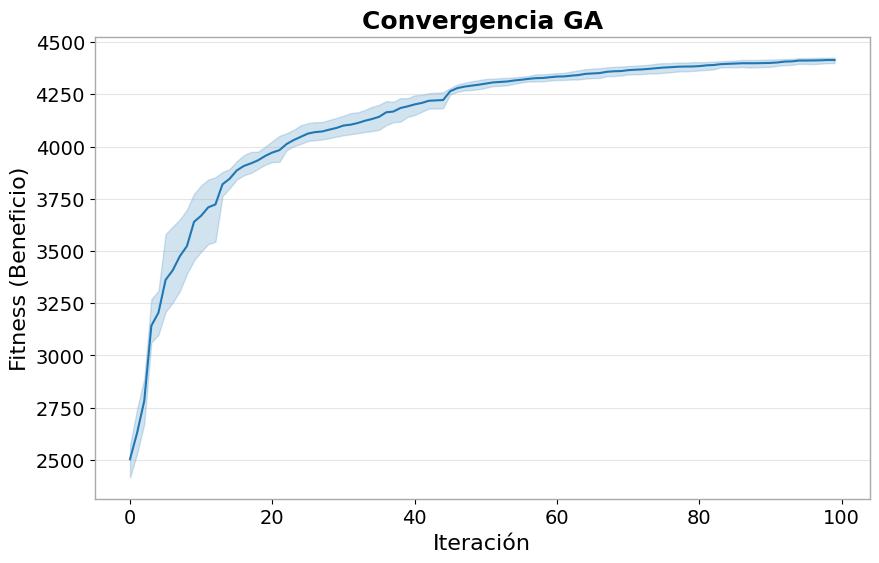

In [64]:
# GSA Convergence plot
sns_line_plot(df=df_gcc,
              x_data="Iteration",
              y_data="Fitness",
              title="Convergencia GA",
              x_label="Iteración",
              y_label="Fitness (Beneficio)",
              save_path=Path('../reports/mealpy/genetic_algo.pdf'))

In [44]:
from scipy import stats

fitness_sCGSA = summary_df['Revenue'].values
fitness_GSA = summary_df_nc['Revenue'].values

fitness_sCGSA, fitness_GSA

(array([2722.30486112, 2253.2369699 , 2239.2765139 , 2107.4293723 ,
        2089.71226206]),
 array([2722.30486112, 2253.2369699 , 2239.2765139 , 2107.4293723 ,
        2089.71226206]))

In [45]:
stat, p_value = stats.wilcoxon(fitness_sCGSA, fitness_GSA)
print(f"Estadístico de Wilcoxon: {stat}, Valor p: {p_value}")

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


ValueError: zero_method 'wilcox' and 'pratt' do not work if x - y is zero for all elements.

In [23]:
sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behaviour=revenue_behaviour,
                         line=line,
                         safe_headway=10)

services = sm.update_supply(path=generator_save_path,
                            solution=gsa_solution[1][0])

sm.update_schedule(solution=gsa_solution[1][0])

filtered_services = {}
for i, service in enumerate(sm.updated_schedule):
    if gsa_solution[1][0].discrete[i]:
        filtered_services[service] = sm.updated_schedule[service]

#plotter = TrainSchedulePlotter(filtered_services, line)
#plotter.plot(plot_security_gaps=True, save_path=Path('../figures/updated.pdf'))

tt_file_name = f'{supply_config_path.stem}_gsa'
print(supply_save_path, tt_file_name)
SupplySaver(services).to_yaml(filename=f'{tt_file_name}.yml', save_path=supply_save_path)

# Copy previous file in reports
shutil.copyfile(f"{supply_save_path}{tt_file_name}.yml", reports_path / f'gsa/{tt_file_name}_25_new.yml')

supply_config_file = Path(f'{supply_save_path}{tt_file_name}.yml')

../configs/gsa_results/ supply_config_gsa


In [24]:
final_supply = Supply.from_yaml(supply_config_file)

{'1_2024-06-25-14.32': {'Madrid': [869.0, 869.0], 'Zaragoza': [966.0, 971.0], 'Tarragona': [1043.0, 1046.0], 'Barcelona': [1096.0, 1096.0]}, '3_2024-06-25-13.47': {'Madrid': [827.0, 827.0], 'Zaragoza': [911.0, 912.0], 'Barcelona': [1012.0, 1012.0]}, '4_2024-06-25-22.34': {'Madrid': [1354.0, 1354.0], 'Barcelona': [1522.0, 1522.0]}, '5_2024-06-25-12.09': {'Lleida': [732.0, 732.0], 'Barcelona': [803.0, 803.0]}, '6_2024-06-25-2.10': {'Madrid': [126.0, 126.0], 'Zaragoza': [205.0, 211.0], 'Tarragona': [270.0, 277.0], 'Barcelona': [317.0, 317.0]}, '8_2024-06-25-8.51': {'Madrid': [530.0, 530.0], 'Zaragoza': [628.0, 631.0], 'Lleida': [690.0, 693.0], 'Barcelona': [782.0, 782.0]}, '10_2024-06-25-12.28': {'Madrid': [748.0, 748.0], 'Barcelona': [923.0, 923.0]}, '12_2024-06-25-6.38': {'Zaragoza': [399.0, 399.0], 'Lleida': [460.0, 464.0], 'Tarragona': [504.0, 507.0], 'Barcelona': [558.0, 558.0]}, '13_2024-06-25-15.39': {'Madrid': [939.0, 939.0], 'Guadalajara': [967.0, 968.0], 'Zaragoza': [1037.0, 104

/Users/david/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


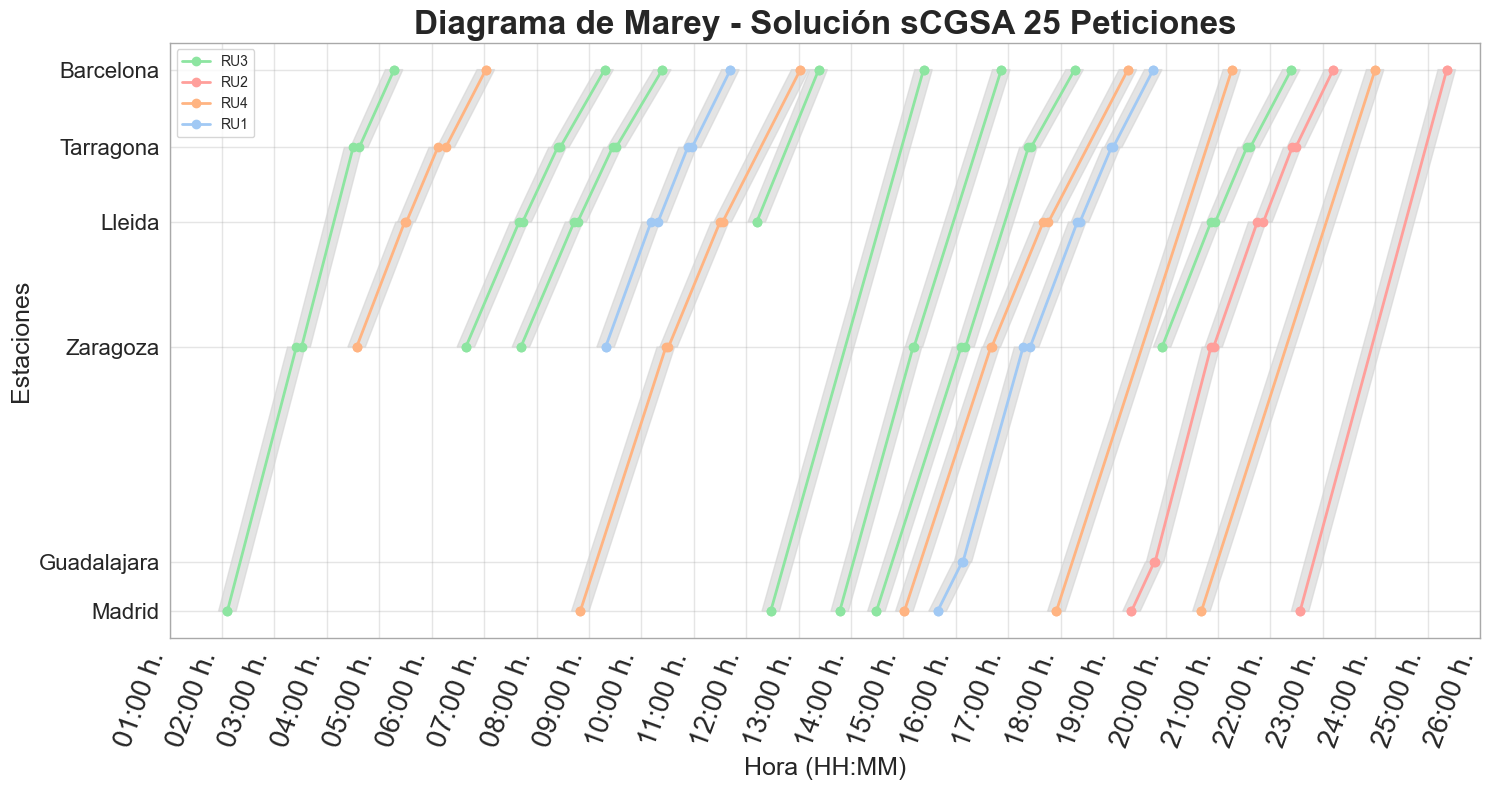

In [25]:
plot_marey_chart(requested_supply=final_supply,
                 colors_by_tsp=True, 
                 main_title="Diagrama de Marey - Solución sCGSA 25 Peticiones",
                 plot_security_gaps=True,
                 security_gap=10,
                 save_path=Path('../reports/gsa/marey_chart_sol_25.pdf'))

In [29]:
shutil.copyfile(f"{supply_save_path}{tt_file_name}.yml", reports_path / f'gsa/{tt_file_name}_25.yml')

PosixPath('../reports/gsa/supply_config_gsa_25.yml')

In [30]:
#!snakeviz profile.pstat